# CEE 690-02

# Environmental Spatial Data Analysis

# Multi-dimensional arrays II

# GDAL for everything? 

* GDAL is terrible when working with a time dimension.
* There are multiple options (e.g., NCO and CDO)
* CDO is an excellent option that we are going to explore

# Situations where this problem matters 

* Comparing two different gridded datasets (e.g., climate model grids vs. observed grids)
* Prepare data for input into an environmental model (e.g., hydrologic model)
* Perform some basic statistical analysis (and save it!)

# Typical issues that have to be addressed

* Datasets to compare are at a different spatial resolution (e.g., 1 arcdegree vs. 0.1 arcdegree)
* Datasets are in different map projections (e.g., latlon vs. equal area)
* Datasets are at different temporal resolution (e.g., daily vs. annual)

# Believe it or not...

If you don't know what tools are out there, solving these issues can take up 90%+ of your research time (this is not an exaggeration!). If you use the right tools from the beginning, when you do the research you can focus on the science. Hence this course...

Tools like CDO become critical at the data processing stage.

# Climate Data Operators (CDO)

The Climate Data Operators (CDO) software is a collection of many operators for standard processing of climate and
forecast model data. The operators include simple statistical and arithmetic functions, data selection and subsampling tools, and spatial interpolation. CDO was developed to have the same set of processing functions for GRIB [GRIB] and NetCDF [NetCDF] datasets in one package.

Source: https://code.mpimet.mpg.de/projects/cdo/wiki/Tutorial

I am going to show you some highlights of CDO. However, just like GDAL, there is much, much more to explore.

# Upscaling in space

Let's upscale our ERA-interim database in space

Let's remind ourselves what is in this dataset

In [205]:
%%bash
cdo -showname /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann

 albedo_sfc blh cape d2m evap evap_snow height_sfc hi_cld land_mask lhflx lo_cld lwflx lwflx_dn mid_cld netflx p_msl p_sfc precip precip_conv precip_ls precip_snow precip_snow_conv precip_snow_ls rh2m runoff shflx swflx swflx_dn t2m t_skin tau_x tau_y tciw tclw tcw tcwv tot_cld wspd10


cdo    showname: Processed 38 variables [0.00s 21MB].


Let's start by learning about the file's current projection information

In [206]:
%%bash
cdo -griddes /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann

#
# gridID 1
#
gridtype  = lonlat
gridsize  = 51840
datatype  = float
xsize     = 288
ysize     = 180
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
xfirst    = 0.625
xinc      = 1.24783
yfirst    = -89.5
yinc      = 1


cdo    griddes: Processed 38 variables [0.00s 21MB].


What do we learn?

* The data is in a regular lon/lat grid (PlateCarree)
* There are 180 pixels along the latitude axis
* There are 288 pixels along the longitude axis
* The longitude of the first pixel on the longitude axis is 0.625
* The latitude of the first pixel on the latitude axis is -89.5
* The spatial resolution of the longitude axis is 0.625 arcdegree
* The spatial resolution of the latitudes axis is 1.0 arcdegree

If we read that into Python...

In [207]:
%matplotlib inline
import netCDF4 as nc
import matplotlib.pyplot as plt
file = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann'
fp = nc.Dataset(file)
print('nlat: %d' % fp['lat'].size)
print('nlon: %d' % fp['lon'].size)
print('dlat: %f' % (fp['lat'][1]-fp['lat'][0]))
print('dlon: %f' % (fp['lon'][1]-fp['lon'][0]))
print('lat0: %f' % (fp['lat'][0]))
print('lon0: %f' % (fp['lon'][0]))
fp.close()

nlat: 180
nlon: 288
dlat: 1.000000
dlon: 1.247830
lat0: -89.500000
lon0: 0.625000


I am given another dataset that is at 5.0 arcdegree spatial resolution in both the lat and lon direction. How can CDO help us?

Let's define the information of the new grid to which we want to map our data

In [208]:
%%writefile ../Workspace/grid.cdo
gridtype  = lonlat
xsize     = 72
ysize     = 36
xname     = lon
xlongname = "longitude" 
xunits    = "degrees_east" 
yname     = lat
ylongname = "latitude" 
yunits    = "degrees_north" 
xfirst    = 2.5
xinc      = 5.0
yfirst    = -87.5
yinc      = 5.0

Overwriting ../Workspace/grid.cdo


CDO then allows us to remap our data to this new grid information.

Let's try a nearest neighbor interpolation (there are many other options). We will only apply it to the t2m (temperature) and precip (precipitation) variables). 

In [209]:
%%bash 
cdo -selname,t2m,precip -remapnn,../Workspace/grid.cdo /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann ../Workspace/example.nc

cdo(1) remapnn: Process started
cdo(1) remapnn: Nearest neighbor weights from lonlat (288x180) to lonlat (72x36) grid
cdo(1) remapnn: Processed 38 variables over 37 timesteps.
cdo    selname: Processed 191808 values from 38 variables [0.65s 26MB].


What did that just do?

In [210]:
%%bash 
cdo -showname ../Workspace/example.nc
cdo -griddes ../Workspace/example.nc

 precip t2m
#
# gridID 1
#
gridtype  = lonlat
gridsize  = 2592
xsize     = 72
ysize     = 36
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
xfirst    = 2.5
xinc      = 5
yfirst    = -87.5
yinc      = 5


cdo    showname: Processed 2 variables [0.00s 21MB].
cdo    griddes: Processed 2 variables [0.00s 21MB].


Let's do a quick plot comparison of the original and new data

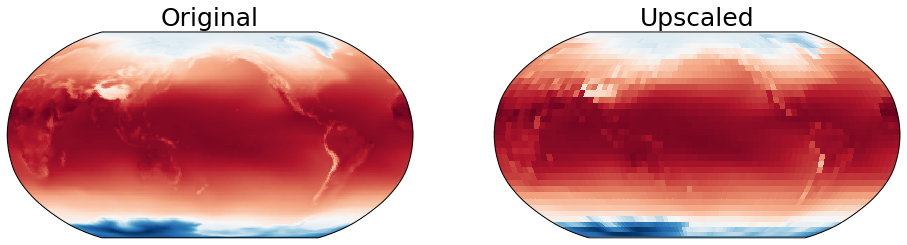

In [175]:
%matplotlib inline
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy
#Extract first time step of each datasets
file = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann'
fp = nc.Dataset(file)
dold = fp['t2m'][0,:,:]
fp.close()
file = '../Workspace/example.nc'
fp = nc.Dataset(file)
dnew = fp['t2m'][0,:,:]
fp.close()
#Make a side by side plot
fig = plt.figure(figsize=(16,8))
img_extent = (-180,180,-90,90)
plt.subplot(121)
ax = plt.subplot(1,2,1,projection=cartopy.crs.Robinson())
ax.imshow(dold,transform=cartopy.crs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),extent=(img_extent))
plt.title('Original',fontsize=25)
plt.subplot(122)
ax = plt.subplot(1,2,2,projection=cartopy.crs.Robinson())
plt.title('Upscaled',fontsize=25)
ax.imshow(dnew,transform=cartopy.crs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),extent=(img_extent))
plt.show()


# Reprojecting/Regridding in space using CDO

Possibilities:

* Reproject the entire database to other projections
* Upscale or downscale in horizontal space
* Extract subsets of the data
* Use a multitude of interpolation schemes (nearest vs. average)
* And many more

# Temporal statistics

Let's learn about the temporal information of our dataset

In [211]:
%%bash
cdo -sinfon /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann

   File format : NetCDF
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name
     1 : unknown  unknown  v instant       1   1     51840   1  F32  : albedo_sfc    
     2 : unknown  unknown  v instant       1   1     51840   1  F32  : blh           
     3 : unknown  unknown  v instant       1   1     51840   1  F32  : cape          
     4 : unknown  unknown  v instant       1   1     51840   1  F32  : d2m           
     5 : unknown  unknown  v instant       1   1     51840   1  F32  : evap          
     6 : unknown  unknown  v instant       1   1     51840   1  F32  : evap_snow     
     7 : unknown  unknown  c instant       1   1     51840   1  F32  : height_sfc    
     8 : unknown  unknown  v instant       1   1     51840   1  F32  : hi_cld        
     9 : unknown  unknown  c instant       1   1     51840   1  F32  : land_mask     
    10 : unknown  unknown  v instant       1   1     51840   1  F32  : lhflx         
    11 : unknown  unknown  v i

cdo    sinfon: Processed 38 variables over 37 timesteps [0.00s 21MB].


Let's compute and save the time average

In [212]:
%%bash
cdo -timmean /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann ../Workspace/example.nc

cdo    timmean: Processed 38 variables over 37 timesteps [0.57s 39MB].


Let's look at the new file

In [213]:
%%bash
cdo -sinfon ../Workspace/example.nc

   File format : NetCDF
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name
     1 : unknown  unknown  v instant       1   1     51840   1  F32  : albedo_sfc    
     2 : unknown  unknown  v instant       1   1     51840   1  F32  : blh           
     3 : unknown  unknown  v instant       1   1     51840   1  F32  : cape          
     4 : unknown  unknown  v instant       1   1     51840   1  F32  : d2m           
     5 : unknown  unknown  v instant       1   1     51840   1  F32  : evap          
     6 : unknown  unknown  v instant       1   1     51840   1  F32  : evap_snow     
     7 : unknown  unknown  c instant       1   1     51840   1  F32  : height_sfc    
     8 : unknown  unknown  v instant       1   1     51840   1  F32  : hi_cld        
     9 : unknown  unknown  c instant       1   1     51840   1  F32  : land_mask     
    10 : unknown  unknown  v instant       1   1     51840   1  F32  : lhflx         
    11 : unknown  unknown  v i

cdo    sinfon: Processed 38 variables over 1 timestep [0.00s 21MB].


You can also do everything at once

In [214]:
%%bash
cdo -timmean -selname,t2m,precip -remapnn,../Workspace/grid.cdo /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann ../Workspace/example.nc

cdo(1) selname: Process started
cdo(2) remapnn: Process started
cdo(2) remapnn: Nearest neighbor weights from lonlat (288x180) to lonlat (72x36) grid
cdo(2) remapnn: Processed 38 variables over 37 timesteps.
cdo(1) selname: Processed 191808 values from 38 variables.
cdo    timmean: Processed 191808 values from 2 variables [0.69s 26MB].


Let's look at what we made

In [215]:
%%bash
cdo -sinfon ../Workspace/example.nc

   File format : NetCDF
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name
     1 : unknown  unknown  v instant       1   1      2592   1  F32  : precip        
     2 : unknown  unknown  v instant       1   1      2592   1  F32  : t2m           
   Grid coordinates :
     1 : lonlat                   : points=2592 (72x36)
                              lon : 2.5 to 357.5 by 5 degrees_east  circular
                              lat : -87.5 to 87.5 by 5 degrees_north
   Vertical coordinates :
     1 : surface                  : levels=1
   Time coordinate :  1 step
     RefTime =  1979-01-01 00:00:00  Units = days  Calendar = standard  Bounds = true
  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss
  1997-07-01 06:00:00


cdo    sinfon: Processed 2 variables over 1 timestep [0.00s 21MB].


We have not even scratched the surface of CDO. Want more information? 

Go here: https://code.mpimet.mpg.de/projects/cdo

And definitely check out the CDO cheat sheet here: 

https://code.mpimet.mpg.de/projects/cdo/embedded/cdo_refcard.pdf

The options are fairly endless...

Annoying aspects of using Python for spatial data (up until now):

* Fairly involved to create a datetime array
* Too many lines just to retrieve the data for a given location
* Can be too involved just to do some basic plots
* Awkward to extract data for a given time stamp
* Main issue: Why should I use it for data exploration?

Wouldn't it be nice if:

* We could just call by a lat/lon pair instead of having to determine the indices?
* We could use a time label to extract data for a time stamp (instead of using masks)?
* We could upscale in time without having to write 30 lines of code?

In other words, wouldn't it be nice if N-dimensional spatial data could be dealt with as we do with data in Pandas?

Well, you are in luck...

<img src="http://xarray.pydata.org/en/v0.10.0/_images/dataset-diagram-logo.png" width="1000">


We are all tired of hearing me explain software packages so...

Let's let one of the core developers of **xarray** do it instead. 

In [1]:
%%html
<iframe width="939" height="528" src="https://www.youtube.com/embed/X0pAhJgySxk" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Let's explore xarray

In [216]:
import xarray as xr

#Open access to the monthly data and print the metadata
file_era_interim = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc'
fp = xr.open_dataset(file_era_interim)

One big difference is the metadata. No need for a ncdump -h to get a general idea of the data.

In [217]:
print(fp)

<xarray.Dataset>
Dimensions:           (bnds: 2, lat: 180, lon: 288, time: 444)
Coordinates:
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon               (lon) float32 0.625 1.8728299 ... 357.50433 358.75217
  * time              (time) datetime64[ns] 1979-01-16T12:00:00 ... 2015-12-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    albedo_sfc        (time, lat, lon) float32 ...
    blh               (time, lat, lon) float32 ...
    cape              (time, lat, lon) float32 ...
    d2m               (time, lat, lon) float32 ...
    evap              (time, lat, lon) float32 ...
    evap_snow         (time, lat, lon) float32 ...
    height_sfc        (lat, lon) float32 ...
    hi_cld            (time, lat, lon) float32 ...
    land_mask         (lat, lon) float32 ...
    lhflx             (time, lat, lon) float32 ...
    lo_cld            (time, lat, lon) float32 ...
    lwflx             (time, lat, lon) float32 ...
    lwflx_d

## You can get more information at the variable level

In [218]:
print(fp['t2m'])

<xarray.DataArray 't2m' (time: 444, lat: 180, lon: 288)>
[23016960 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.625 1.8728299 3.1206598 ... 357.50433 358.75217
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2015-12-16T12:00:00
Attributes:
    long_name:  temperature at 2m
    units:      degC
    history:    From /dev/shm/monthly_an_sfc.nc


## Sampling data from Durham: Revisited

In [219]:
#Geographic coordinates for Durham
lat = 35.9940
lon = -78.8986 + 360.0
#Extract the data
data = fp['t2m'].sel(lat=lat,lon=lon,method='nearest')
#Print the metadata
print(data)

<xarray.DataArray 't2m' (time: 444)>
array([ 4.466494,  3.207048, 11.521636, ..., 16.407286, 13.70421 , 13.706179],
      dtype=float32)
Coordinates:
    lat      float32 35.5
    lon      float32 281.38672
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2015-12-16T12:00:00
Attributes:
    long_name:  temperature at 2m
    units:      degC
    history:    From /dev/shm/monthly_an_sfc.nc


## Making plots is incredibly easy

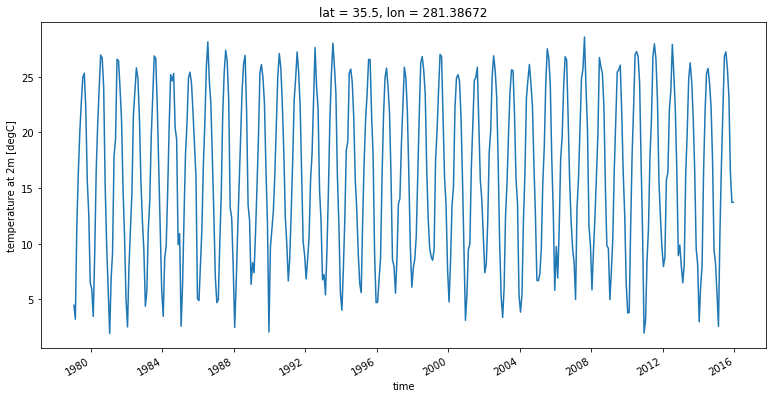

In [221]:
#It evens makes plots much easier
plt.figure(figsize=(13,6))
data.plot()
plt.show()

## Upscale to annual time step

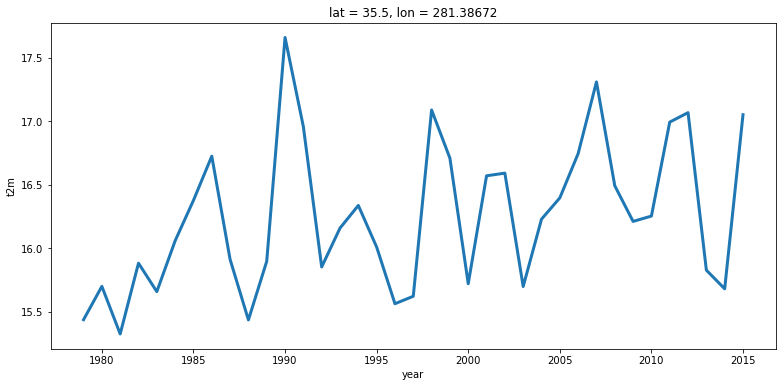

In [222]:
#We can quickly upscale to an annual time step and make the plot
plt.figure(figsize=(13,6))
data.groupby('time.year').mean('time').plot(lw=3)
plt.show()

## Compute and plot the monthly climatology

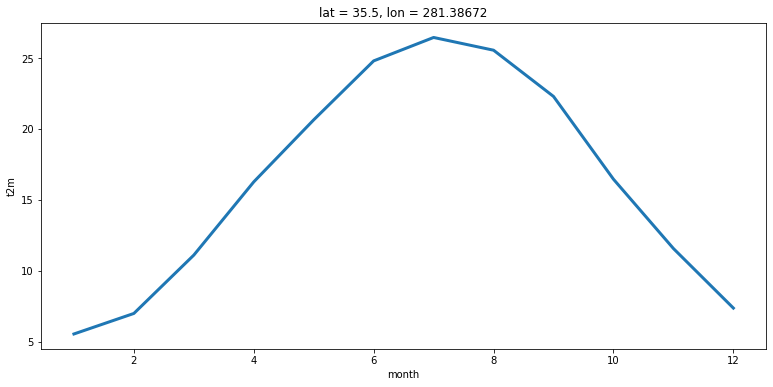

In [188]:
plt.figure(figsize=(13,6))
data.groupby('time.month').mean('time').plot(lw=3)
plt.show()

## Plot the histogram

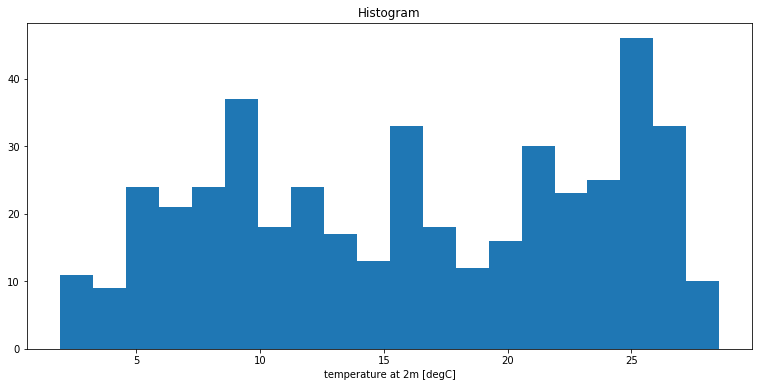

In [189]:
plt.figure(figsize=(13,6))
data.plot.hist(bins=20)
plt.show()

## Subset via labels

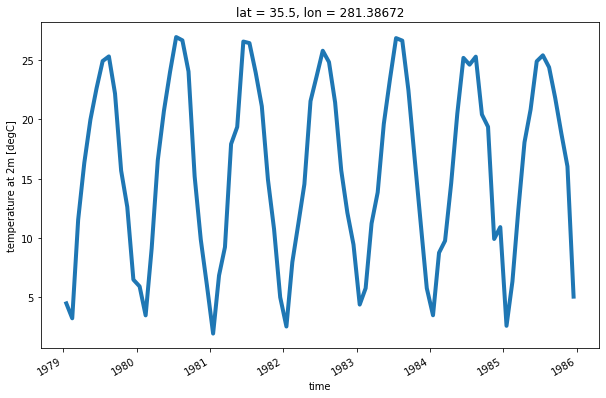

In [190]:
plt.figure(figsize=(10,6))
data.loc[slice('1979','1985')].plot(lw=4)

## Subset the data in space and time (but with labels!)

In [223]:
#We can directly subset the larger dataset for a given region
data = fp['t2m'].sel(time=slice('1979','1990'),lat=slice(20,60),lon=slice(220,310))
print(data)

<xarray.DataArray 't2m' (time: 144, lat: 40, lon: 72)>
[414720 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 55.5 56.5 57.5 58.5 59.5
  * lon      (lon) float32 220.24306 221.49089 222.73871 ... 307.59116 308.839
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 1990-12-16T12:00:00
Attributes:
    long_name:  temperature at 2m
    units:      degC
    history:    From /dev/shm/monthly_an_sfc.nc


## Make a quick spatial plot

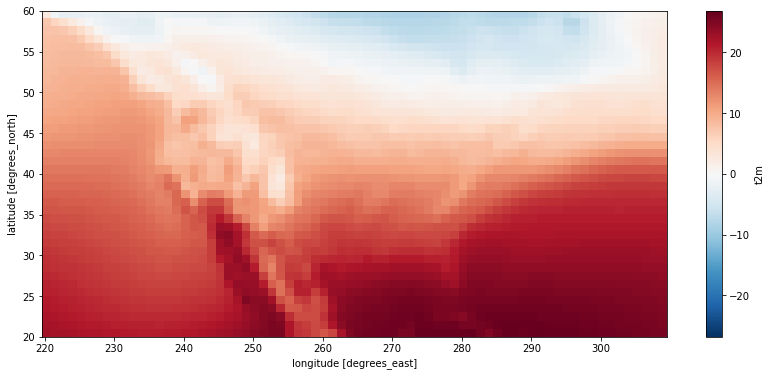

In [224]:
plt.figure(figsize=(14,6))
data.mean('time').plot.imshow()
plt.show()

## Add in Cartopy

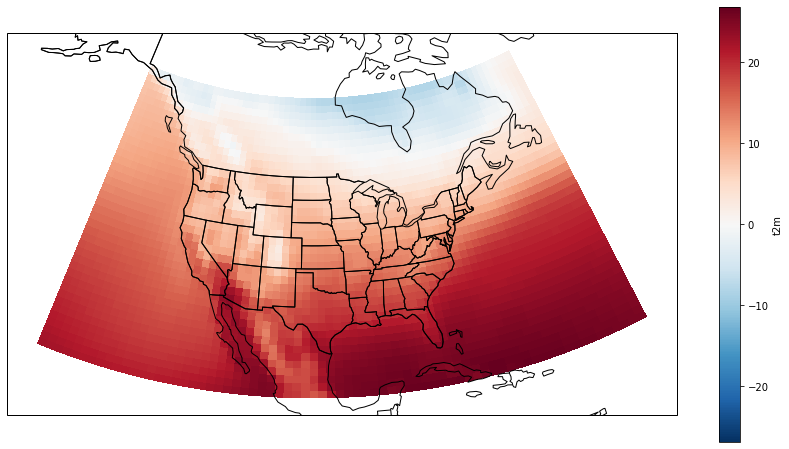

In [193]:
import cartopy
plt.figure(figsize=(15,8))
ax = plt.subplot(projection=cartopy.crs.AlbersEqualArea(standard_parallels=(20,50),
                                                        central_longitude=260,
                                                        central_latitude=45))
data.mean('time').plot.pcolormesh(transform=cartopy.crs.PlateCarree(),add_colorbar=True)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
plt.show()

## Computing temporal statistics

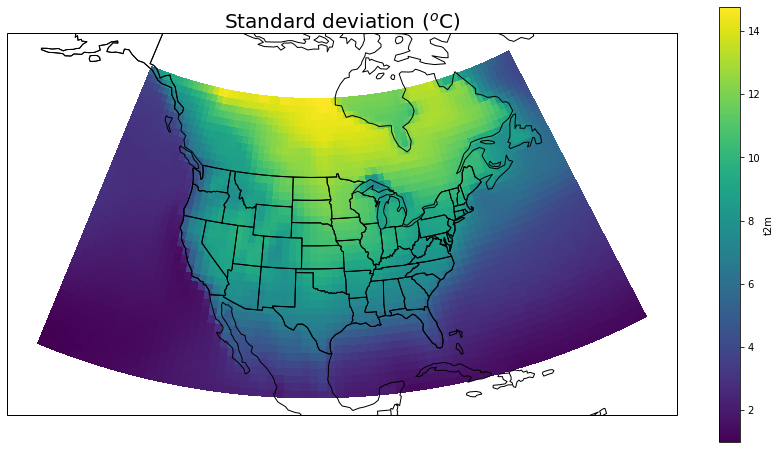

In [200]:
plt.figure(figsize=(15,8))
ax = plt.subplot(projection=cartopy.crs.AlbersEqualArea(standard_parallels=(20,50),
                                                        central_longitude=260,
                                                        central_latitude=45))
data.std('time').plot.pcolormesh(transform=cartopy.crs.PlateCarree(),add_colorbar=True)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
plt.title(r'Standard deviation ($^o$C)',fontsize=20)
plt.show()

## We can always just treat them as numpy arrays as well

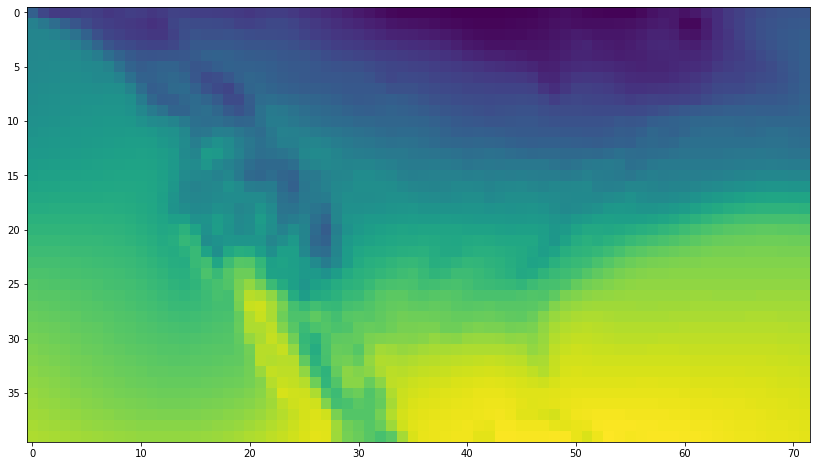

In [201]:
tmp = np.mean(data,axis=0)
plt.figure(figsize=(16,8))
plt.imshow(np.flipud(tmp))
plt.show()

## Writing data made incredibly easy

In [225]:
data.to_netcdf('../Workspace/test.nc')

In [226]:
%%bash
ncdump -h ../Workspace/test.nc

netcdf test {
dimensions:
	lat = 40 ;
	lon = 72 ;
	time = 144 ;
variables:
	float lat(lat) ;
		lat:_FillValue = NaNf ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float lon(lon) ;
		lon:_FillValue = NaNf ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double time(time) ;
		time:_FillValue = NaN ;
		time:standard_name = "time" ;
		time:long_name = "time" ;
		time:bounds = "time_bnds" ;
		time:axis = "T" ;
		time:units = "days since 1979-01-01" ;
		time:calendar = "standard" ;
	float t2m(time, lat, lon) ;
		t2m:_FillValue = -1.e+34f ;
		t2m:long_name = "temperature at 2m" ;
		t2m:units = "degC" ;
		t2m:history = "From /dev/shm/monthly_an_sfc.nc" ;
		t2m:missing_value = -1.e+34f ;
}


## Learn xarray

Resources? Start here: http://xarray.pydata.org/en/stable/

## Word of caution

* Xarray is very powerful and you should definitely use it.
* However, note that the easier a software package makes things, (in most cases) the less control we have.
* There are many circumstances where xarray could be limiting (probably not in this course though).
* It is good to know what is happening under the hood so you dig deeper when necessary.

# Too many options?

* Presented with a lot of packages and tools that do similar things.
* Which ones you use and how you combine them is a personal choice.
* I am just presenting many good options that will help you solve your current/future research question.